In [1]:
import pandas as pd 

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

pd.options.display.max_columns = None

pd.options.display.max_rows = None
 
pd.options.display.float_format = '{:.6f}'.format

from sklearn.model_selection import train_test_split

import statsmodels
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
plt.rcParams['figure.figsize'] = [15,8]

In [2]:
df = pd.read_csv('data_mm_transf-.csv')
df.head()

,funded_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,collections_12_mths_ex_med,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status,rec_and_col_fee,emi_paid_progress_perc
0,14350,36 months,19.190000,others,High,OWN,28700.000000,Verified,debt_consolidation,33.880000,50.000000,14,1,22515.000000,73.100000,28,f,1173.840000,0.000000,0.000000,0.000000,28699.000000,30800.000000,0,0.000000,16.560510
1,4800,36 months,10.990000,B,Low,MORTGAGE,65000.000000,Verified,home_improvement,3.640000,34.000000,6,0,7624.000000,23.200000,13,w,83.950000,0.000000,0.000000,0.000000,9974.000000,32900.000000,0,0.000000,5.732484
2,10000,36 months,7.260000,A,Low,OWN,45000.000000,Not Verified,debt_consolidation,18.420000,36.000000,5,0,10877.000000,31.200000,19,w,56.470000,0.000000,0.000000,65.000000,38295.000000,34900.000000,0,0.000000,5.732484
3,15000,36 months,19.720000,D,High,RENT,105000.000000,Not Verified,debt_consolidation,14.970000,46.000000,10,0,13712.000000,55.500000,21,f,4858.620000,0.000000,0.000000,0.000000,55564.000000,24700.000000,0,0.000000,85.987261
4,16000,36 months,10.640000,B,High,RENT,52000.000000,Verified,credit_card,20.160000,34.000000,11,0,35835.000000,76.200000,27,w,2296.410000,0.000000,0.000000,0.000000,47159.000000,47033.000000,0,0.000000,61.146497


### Split the dependent and independent variables

In [3]:
df_target = df['loan_status']

df_feature = df.drop('loan_status', axis = 1)

## Distribution of dependent variable.

In [4]:
df_target.value_counts()

0    406389
1    125668
Name: loan_status, dtype: int64

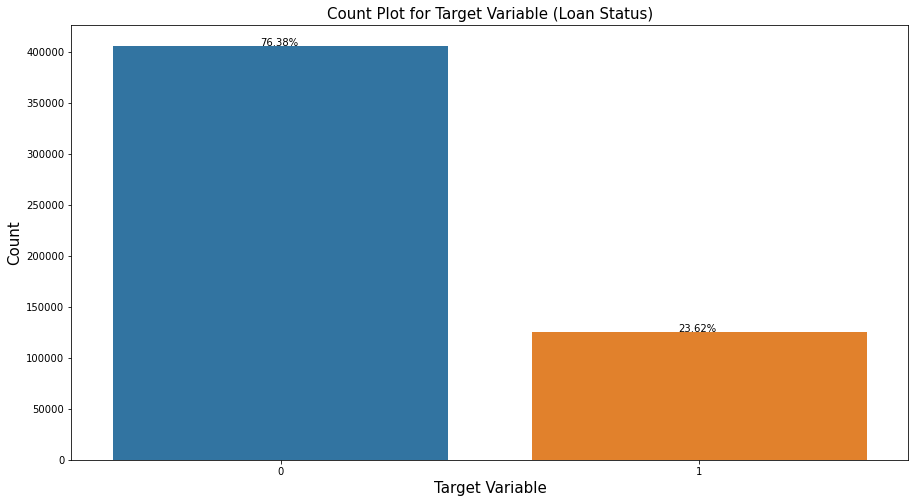

In [5]:
sns.countplot(x = df_target)


plt.text(x = -0.05, y = df_target.value_counts()[0] + 1, s = str(round((df_target.value_counts()[0])*100/len(df_target),2)) + '%')
plt.text(x = 0.95, y = df_target.value_counts()[1] +1, s = str(round((df_target.value_counts()[1])*100/len(df_target),2)) + '%')


plt.title('Count Plot for Target Variable (Loan Status)', fontsize = 15)
plt.xlabel('Target Variable', fontsize = 15)
plt.ylabel('Count', fontsize = 15)


plt.show()

#### <span style="color:#1c474d">
76.38% people are non-defaulters, 23.62% are defaulters in the target variable 'loan_status'
</span>

## Filter numerical and categorical variables.

In [6]:
num_f = df_feature.select_dtypes(include=[np.number])

num_f.columns

Index(['funded_amnt', 'int_rate', 'annual_inc', 'dti',
       'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'total_rec_int', 'total_rec_late_fee',
       'collections_12_mths_ex_med', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim', 'rec_and_col_fee', 'emi_paid_progress_perc'],
      dtype='object')

In [7]:
cat_f = df_feature.select_dtypes(exclude=[np.number])
cat_f.columns

Index(['term', 'grade', 'emp_length', 'home_ownership', 'verification_status',
       'purpose', 'initial_list_status'],
      dtype='object')

## Dummy Encode the Categorical Variables

In [8]:
df_cat = pd.get_dummies(cat_f, drop_first=True)

## Scale the Data

We scale the variables to get all the variables in the same range. With this, we can avoid a problem in which some features come to dominate solely because they tend to have larger values than others.

In [9]:
X_scaler = StandardScaler()

num_scaled = X_scaler.fit_transform(num_f)

df_num_scaled = pd.DataFrame(num_scaled, columns = num_f.columns)

#### Concatenating scaled numerical and dummy encoded categorical variables

In [10]:
df_features = pd.concat([df_cat,df_num_scaled], axis =1)
df_features.shape

(532057, 33)

## Train-Test Split

Before applying various classification techniques to predict the loan status of the customers, we split the dataset in train and test set.

In [11]:
df_1 = sm.add_constant(df_features)

x_train, x_test ,y_train ,y_test = train_test_split(df_1,df_target, random_state=1, test_size=0.3)


print('x_train: ',x_train.shape)
print('y_train: ',y_train.shape)
print('x_test: ',x_test.shape)
print('y_test: ',y_test.shape)

x_train:  (372439, 34)
y_train:  (372439,)
x_test:  (159618, 34)
y_test:  (159618,)


#### Create a generalized function to create a dataframe containing the scores for the models.

In [12]:
score_card = pd.DataFrame(columns=['Probability Cutoff', 'AUC Score', 'Precision Score', 'Recall Score',
                                       'Accuracy Score', 'Kappa Score', 'f1-score'])

def update_score_card(model, cutoff):
    
    # let 'y_pred_prob' be the predicted values of y
    y_pred_prob = logreg.predict(x_test)

    # convert probabilities to 0 and 1 using 'if_else'
    y_pred = [ 0 if x < cutoff else 1 for x in y_pred_prob]
    
    # assign 'score_card' as global variable
    global score_card

    # append the results to the dataframe 'score_card'
    # 'ignore_index = True' do not consider the index labels
    score_card = score_card.append({'Probability Cutoff': cutoff,
                                    'AUC Score' : metrics.roc_auc_score(y_test, y_pred_prob),
                                    'Precision Score': metrics.precision_score(y_test, y_pred),
                                    'Recall Score': metrics.recall_score(y_test, y_pred),
                                    'Accuracy Score': metrics.accuracy_score(y_test, y_pred),
                                    'Kappa Score':metrics.cohen_kappa_score(y_test, y_pred),
                                    'f1-score': metrics.f1_score(y_test, y_pred)}, 
                                    ignore_index = True)

## Logistic Regression (Full Model)

#### Build a full logistic model on a training dataset

In [13]:
logreg = sm.Logit(y_train,x_train).fit()

print(logreg.summary())

         Current function value: 0.458857
         Iterations: 35


C:\Users\User\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:               372439
Model:                          Logit   Df Residuals:                   372405
Method:                           MLE   Df Model:                           33
Date:                Fri, 12 Aug 2022   Pseudo R-squ.:                  0.1614
Time:                        20:10:27   Log-Likelihood:            -1.7090e+05
converged:                      False   LL-Null:                   -2.0380e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          -48.2482     69.097     -0.698      0.485    -183.676      87.179
term_60 months                  -0.2542      0.013    -19.589      0.000     

In [14]:
insignificant = pd.DataFrame(logreg.pvalues[logreg.pvalues>0.05][1:],columns=['p_value'])

In [15]:
print([i for i in insignificant.index])

['purpose_home_improvement', 'annual_inc', 'rec_and_col_fee']


#### <span style="color:#1c474d">
1. Pseudo R-squ. of the model is : 0.1614
    
2. Log-Likelihood of the model is : -1.7090e+05
    
3. Log-Likelihood of the NULL model is : -2.0380e+05
    
    We expect the Log-Likelihood of our model to be greater than the Log-Likelihood of null model !
    
    
4. LLR p-value of the model is : 0.000
       Since, LLR p-value < 0.05, we reject the null Hypothesis and accept Alternate Hypothesis.
       i.e. There exist atleast one significant feature in our model !      
                                 
5. The insignificant features are 'purpose_home_improvement',annual_inc','rec_and_col_fee'
</span>

#### AIC (Akaike Information Criterion) value.

It is a relative measure of model evaluation. It gives a trade-off between model accuracy and model complexity.

In [16]:
print('AIC:', logreg.aic)

AIC: 341860.12227284646


###  The odds for each variable

In [17]:
df_odds = pd.DataFrame(np.exp(logreg.params), columns= ['Odds']) 
df_odds

,Odds
const,0.000000
term_60 months,0.775555
grade_B,0.457279
grade_C,0.217451
grade_D,0.109402
grade_others,0.047643
emp_length_Low,1.100759
emp_length_Medium,1.074842
home_ownership_OTHERS,11.522067
home_ownership_OWN,0.812415


###  Prediction

In [18]:
y_pred_prob = logreg.predict(x_test)

y_pred_prob.head()

189102   0.354066
341768   0.217883
344879   0.188036
363549   0.059453
106309   0.112963
dtype: float64

Since the target variable can take only two values either 0 or 1. We decide the cut-off of 0.5. i.e. if 'y_pred_prob' is less than 0.5, then consider it to be 0 else consider it to be 1.

In [19]:
y_pred = [ 0 if x < 0.5 else 1 for x in y_pred_prob]

In [20]:
# print the first five observations of y_pred
y_pred[0:5]

[0, 0, 0, 0, 0]

### Plot the confusion matrix.

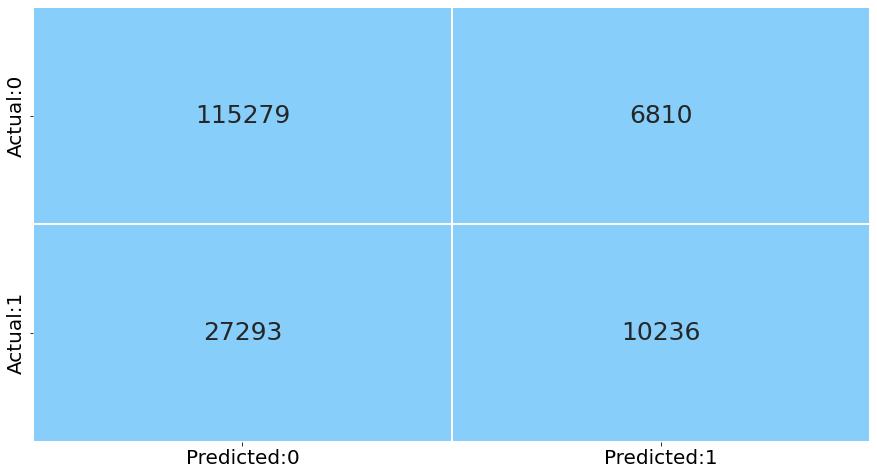

In [21]:
cm = confusion_matrix(y_test, y_pred)

conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])

sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = ListedColormap(['lightskyblue']), cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})

plt.xticks(fontsize = 20)


plt.yticks(fontsize = 20)

plt.show()

In [22]:
TN = cm[0,0]

TP = cm[1,1]

FP = cm[0,1]

FN = cm[1,0]

In [23]:
print('True Negative : ', TN)
print('True Positive : ',TP)
print('False Positive : ',FP)
print('False Negative : ',FN)

True Negative :  115279
True Positive :  10236
False Positive :  6810
False Negative :  27293


In [24]:
acc_table = classification_report(y_test, y_pred)

print(acc_table)

              precision    recall  f1-score   support

           0       0.81      0.94      0.87    122089
           1       0.60      0.27      0.38     37529

    accuracy                           0.79    159618
   macro avg       0.70      0.61      0.62    159618
weighted avg       0.76      0.79      0.75    159618



Since, we wouldnt want to wrongly classify the actual defaulters as non defaulters i.e reduce Type-II Error as much as possible. 
This can be done by focussing on the recall i.e. 0.27 for the model, since it is a component of Type-II Error which effects the prediction of the model.

### Kappa score

In [25]:
# compute the kappa value
kappa = cohen_kappa_score(y_test, y_pred)

# print the kappa value
print('kappa value:',kappa)

kappa value: 0.26753735586122906


The inter-rater reliability of the model is very low. thus, we can't rely on this model.

### Plot the ROC curve

ROC curve is plotted with the true positive rate (tpr) on the y-axis and false positive rate (fpr) on the x-axis. The area under this curve is used as a measure of separability of the model.

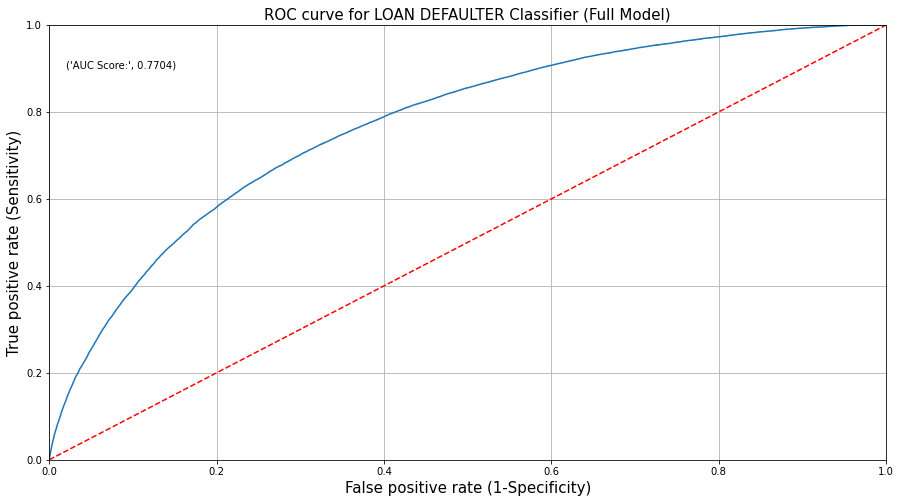

In [26]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.plot([0, 1], [0, 1],'r--')

# add plot and axes labels
# set text size using 'fontsize'
plt.title('ROC curve for LOAN DEFAULTER Classifier (Full Model)', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

# add the AUC score to the plot
# 'x' and 'y' gives position of the text
# 's' is the text 
# use round() to round-off the AUC score upto 4 digits
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(y_test, y_pred_prob),4)))
                               
# plot the grid
plt.grid(True)

### Interpretation: 
The red dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).
From the above plot, we can see that our classifier (logistic regression) is away from the dotted line; with the AUC score 0.7704.

In [28]:
metrics.accuracy_score(y_test, y_pred)

0.7863461514365547

In [29]:
cutoff = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for value in cutoff:
    update_score_card(logreg, value)

In [30]:
print('Score Card for Logistic regression:')

score_card = score_card.sort_values('Probability Cutoff').reset_index(drop = True)

score_card.style.highlight_max(color = 'lightblue', subset = ['AUC Score', 'Accuracy Score', 'Kappa Score', 'f1-score'])

Score Card for Logistic regression:


,Probability Cutoff,AUC Score,Precision Score,Recall Score,Accuracy Score,Kappa Score,f1-score
0,0.100000,0.770387,0.296274,0.941778,0.460362,0.144859,0.450747
1,0.200000,0.770387,0.388207,0.764715,0.661329,0.295137,0.514983
2,0.300000,0.770387,0.471529,0.582083,0.748355,0.352896,0.521006
3,0.400000,0.770387,0.540862,0.413360,0.779567,0.332653,0.468593
4,0.500000,0.770387,0.600493,0.272749,0.786346,0.267537,0.375117
5,0.600000,0.770387,0.667381,0.157558,0.783464,0.181412,0.254931
6,0.700000,0.770387,0.733008,0.064084,0.774462,0.083203,0.117863
7,0.800000,0.770387,0.765957,0.011511,0.766762,0.015829,0.022681
8,0.900000,0.770387,0.945946,0.000933,0.765089,0.001401,0.001863


The Logistic Regression model we’ve built will help the bank to predict the defaulters on the basis of their details with an accuracy of 78%.

Threshold of 0.3 has the best AUC Score, Kappa Score and f-1 score thus, we’ll use 0.3 as a threshold for building the future Logistic Regression models.

Since, the initial model we built is based on imbalanced target feature, we shouldn’t be focussing on the accuracy score to decide the best threshold value, because the model would be biased towards a particular sub class.
